In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import Tool
import numpy as np
import tqdm
import tejapi
from datetime import datetime, timedelta

In [4]:
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')

In [33]:
twse = tejapi.get('TWN/APIPRCD', coid='IX0001',opts={'columns': ['mdate','roi','close_d','vol','low_d','open_d','high_d']}, mdate={'gte': '2010-01-01', 'lte':'2025-04-21'}, paginate=True)

In [34]:
twse['roi'] = (twse['roi'] / 100).shift(-2)
twse.set_index('mdate', inplace=True)

In [3]:
import os
import matplotlib
import tejapi
font_path_microsoft = r'C:\Users\User\OneDrive\文件\medina\simhei.ttf'
font_path_arial = r'C:\Users\User\OneDrive\文件\medina\Arial Unicode MS.ttf'

if os.path.isfile(font_path_microsoft):
    matplotlib.font_manager.fontManager.addfont(font_path_microsoft)
if os.path.isfile(font_path_arial):
    matplotlib.font_manager.fontManager.addfont(font_path_arial)
matplotlib.rc('font', family='sans-serif')

os.environ['TEJAPI_KEY'] = 'SZf1BjNEcKQhvQmn96eLrNL60Q2RH1'
os.environ['TEJAPI_BASE'] = 'https://api.tej.com.tw'
tejapi.ApiConfig.api_base = 'https://api.tej.com.tw'
tejapi.ApiConfig.api_key = 'SZf1BjNEcKQhvQmn96eLrNL60Q2RH1'
tejapi.ApiConfig.ignoretz = True
from zipline.sources.TEJ_Api_Data import get_universe

In [6]:
handler = MBQ_tej_v2_manager.Handler()
close = handler('Close')
volume = handler('vol') * 1000
ind_df= handler('Industry')
mv_df = handler('mktcap')

TWN/APIPRCD
close_d
C:\Users\User/Documents\MBQ_tej_v2_DB\TWN/APIPRCD\close_d.parquet
Custom
Common_Stock
C:\Users\User/Documents\MBQ_tej_v2_DB\Custom\Common_Stock.parquet
分布式讀取:C:\Users\User/Documents\MBQ_tej_v2_DB\Custom\Common_Stock.parquet
Start to update雲端 close_d from 2025-04-21 00:00:00 to 2025-04-21 00:00:00
tej_fastget:TWN/APIPRCD:close_d
分布式更新:C:\Users\User\我的雲端硬碟 (owen.lin@mutual-boost.com)\MBQ_Tej_v2\MBQ_tej_v2\TWN/APIPRCD\close_d


Processing files: 100%|██████████| 1/1 [00:00<00:00, 14.34it/s]

Start to update本地 close_d from 2025-04-21 00:00:00 to 2025-04-21 00:00:00
分布式讀取:C:\Users\User\我的雲端硬碟 (owen.lin@mutual-boost.com)\MBQ_Tej_v2\MBQ_tej_v2\TWN/APIPRCD\close_d


分布式讀取:C:\Users\User/Documents\MBQ_tej_v2_DB\TWN/APIPRCD\close_d.parquet
TWN/APIPRCD
vol
C:\Users\User/Documents\MBQ_tej_v2_DB\TWN/APIPRCD\vol.parquet
Custom
Common_Stock
C:\Users\User/Documents\MBQ_tej_v2_DB\Custom\Common_Stock.parquet
分布式讀取:C:\Users\User/Documents\MBQ_tej_v2_DB\Custom\Common_Stock.parquet
Start to update雲端 vol from 2025-04-21 00:00:00 to 2025-04-21 00:00:00
tej_fastget:TWN/APIPRCD:vol
分布式更新:C:\Users\User\我的雲端硬碟 (owen.lin@mutual-boost.com)\MBQ_Tej_v2\MBQ_tej_v2\TWN/APIPRCD\vol


Processing files: 100%|██████████| 1/1 [00:00<00:00, 22.32it/s]

Start to update本地 vol from 2025-04-21 00:00:00 to 2025-04-21 00:00:00
分布式讀取:C:\Users\User\我的雲端硬碟 (owen.lin@mutual-boost.com)\MBQ_Tej_v2\MBQ_tej_v2\TWN/APIPRCD\vol


分布式讀取:C:\Users\User/Documents\MBQ_tej_v2_DB\TWN/APIPRCD\vol.parquet
TWN/APISTKATTR
main_ind_c
C:\Users\User/Documents\MBQ_tej_v2_DB\TWN/APISTKATTR\main_ind_c.parquet
Custom
Common_Stock
C:\Users\User/Documents\MBQ_tej_v2_DB\Custom\Common_Stock.parquet
分布式讀取:C:\Users\User/Documents\MBQ_tej_v2_DB\Custom\Common_Stock.parquet
Start to update雲端 main_ind_c from 2025-04-21 00:00:00 to 2025-04-21 00:00:00
tej_fastget:TWN/APISTKATTR:main_ind_c
分布式更新:C:\Users\User\我的雲端硬碟 (owen.lin@mutual-boost.com)\MBQ_Tej_v2\MBQ_tej_v2\TWN/APISTKATTR\main_ind_c


Processing files: 100%|██████████| 1/1 [00:00<00:00, 17.04it/s]

Start to update本地 main_ind_c from 2025-04-21 00:00:00 to 2025-04-21 00:00:00
分布式讀取:C:\Users\User\我的雲端硬碟 (owen.lin@mutual-boost.com)\MBQ_Tej_v2\MBQ_tej_v2\TWN/APISTKATTR\main_ind_c


分布式讀取:C:\Users\User/Documents\MBQ_tej_v2_DB\TWN/APISTKATTR\main_ind_c.parquet
TWN/APIPRCD
mktcap
C:\Users\User/Documents\MBQ_tej_v2_DB\TWN/APIPRCD\mktcap.parquet
Custom
Common_Stock
C:\Users\User/Documents\MBQ_tej_v2_DB\Custom\Common_Stock.parquet
分布式讀取:C:\Users\User/Documents\MBQ_tej_v2_DB\Custom\Common_Stock.parquet
Start to update雲端 mktcap from 2025-04-21 00:00:00 to 2025-04-21 00:00:00
tej_fastget:TWN/APIPRCD:mktcap
分布式更新:C:\Users\User\我的雲端硬碟 (owen.lin@mutual-boost.com)\MBQ_Tej_v2\MBQ_tej_v2\TWN/APIPRCD\mktcap


Processing files: 100%|██████████| 1/1 [00:00<00:00, 20.62it/s]

Start to update本地 mktcap from 2025-04-21 00:00:00 to 2025-04-21 00:00:00
分布式讀取:C:\Users\User\我的雲端硬碟 (owen.lin@mutual-boost.com)\MBQ_Tej_v2\MBQ_tej_v2\TWN/APIPRCD\mktcap


分布式讀取:C:\Users\User/Documents\MBQ_tej_v2_DB\TWN/APIPRCD\mktcap.parquet


In [7]:
rs_1 = pd.read_parquet('RS_part1.parquet')
rs_2 = pd.read_parquet('RS_part2.parquet')
rs = pd.concat([rs_1, rs_2], ignore_index=True)
rs['日期'] = pd.to_datetime(rs['日期'], format='%Y%m%d')

In [8]:
rs['股票代號'] = rs['股票代號'].astype(str)
rs_short = rs.pivot(index='日期', columns='股票代號', values='短RS').reindex(index = close.index, columns = close.columns).dropna(axis=0, how='all')
rs_long = rs.pivot(index='日期', columns='股票代號', values='長RS').reindex(index = close.index, columns = close.columns).dropna(axis=0, how='all')

In [9]:
cross_signal = (rs_short > rs_long).astype(int)
signal_change = cross_signal.diff().fillna(0)
position = (rs_short > rs_long).astype(int)
daily_return = close.shift(-2) / close.shift(-1) - 1 
strategy_return = position * daily_return
daily_strategy_return = strategy_return.mean(axis=1)
Tool.show_stats(daily_strategy_return)
daily_strategy_return.cumsum().iplot()

,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),样本胜率(%),周胜率(%),月胜率(%),年胜率(%),盈亏比(avg_win/avg_loss),总赚赔比(profit_factor),预期报酬(bps),样本数
策略,0.81,0.23,0.04,-20.21,-21.65,58.6,58.92,54.89,68.75,0.74,1.04,0.48,3737


In [10]:
forward_return = close.shift(-6) / close.shift(-1) - 1
twse['roi'].index = forward_return.index
excess_return = forward_return.sub(twse['roi'], axis=0)

# 行業分層回測

In [11]:
def max_drawdown(prices):
    # 計算累計的最大值
    cumulative_max = prices.cummax()
    # 計算回撤 (Drawdown)
    drawdown = (prices - cumulative_max) / cumulative_max
    # 計算最大回撤 (MDD)
    mdd = drawdown.min()
    return mdd
def show_bt(bt_ret):
    display(pd.concat({"CAGR(%)":bt_ret.mean() * 252,
            'Sharpe' : bt_ret.mean() / bt_ret.std()*252**0.5,
            'Calmar':bt_ret.calmar(),
            'MDD(%)' : bt_ret.max_drawdown()*100,
            '單利MDD(%)' : max_drawdown(bt_ret.cumsum().add(1))*100,
            '樣本勝率(%)' : bt_ret.apply(lambda X:((X.dropna()>0).sum() / X.dropna().shape[0])*100),
            '周勝率(%)' : bt_ret.apply(lambda X:((X.dropna().add(1).resample('W').prod().sub(1)>0).sum() / X.dropna().add(1).resample('W').prod().sub(1).dropna().shape[0])*100),
            '月勝率(%)' : bt_ret.apply(lambda X:((X.dropna().add(1).resample('ME').prod().sub(1)>0).sum() / X.dropna().add(1).resample('ME').prod().sub(1).shape[0])*100),
            '年勝率(%)' : bt_ret.apply(lambda X:((X.dropna().add(1).resample('YE').prod().sub(1)>0).sum() / X.dropna().add(1).resample('YE').prod().sub(1).shape[0])*100),
            'avg_win/avg_loss' : bt_ret.apply(lambda X:(X[X > 0].mean() / abs(X[X < 0].mean()))),
            'profit_factor' : bt_ret.profit_factor(),
            },axis = 1).round(2))
def backtest_factor(factor:pd.DataFrame,exp_ret:pd.DataFrame,rank_range_n:int = 10,start_date:str = '2015-01-01'):
    factor_rank = factor.rank(axis = 1,pct = True,method = 'first')

    IC_Se = factor.corrwith(exp_ret,axis=1,method='spearman').sort_index().loc[start_date:]
    print(f'IC_mean:{round(IC_Se.mean(),4)}')
    print(f'IC_IR:{round(IC_Se.mean()/IC_Se.std(),4)}')

    bt = pd.concat({f'{int(((_/rank_range_n)*100))}% ~ {int((_+1)/rank_range_n*100)}%':exp_ret[(factor_rank>_/rank_range_n) & (factor_rank<=(_+1)/rank_range_n)].mean(axis = 1) - exp_ret.mean(axis=1) for _ in tqdm.tqdm(range(rank_range_n))}, axis = 1).dropna(how = 'all')
    bt = bt.loc[start_date:]
    if (bt.iloc[:,-1] - bt.iloc[:,0]).add(1).prod() > 1:
        bt['LS_ret'] = bt.iloc[:,-1] - bt.iloc[:,0]
    else:
        bt['LS_ret'] = bt.iloc[:,0] - bt.iloc[:,-1]
    show_bt(bt)

    (bt.drop(columns='LS_ret').loc[start_date:].cagr()*100).iplot(kind = 'bar')
backtest_factor(rs_short,excess_return,rank_range_n = 10,start_date = '2020-01-01')

IC_mean:-0.0324
IC_IR:-0.2493


100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,0.01,0.07,-0.00,-43.79,-45.05,47.56,45.82,46.88,50.00,1.12,1.01
10% ~ 20%,-0.15,-1.11,-0.15,-67.63,-86.74,43.40,39.64,34.38,33.33,1.07,0.82
20% ~ 30%,-0.20,-1.81,-0.17,-72.73,-103.57,41.51,38.55,35.94,16.67,1.04,0.74
30% ~ 40%,-0.19,-2.06,-0.18,-65.86,-96.57,41.43,38.91,29.69,16.67,1.00,0.71
40% ~ 50%,-0.26,-3.24,-0.22,-73.08,-129.35,39.86,35.27,23.44,0.00,0.89,0.59
50% ~ 60%,-0.27,-3.52,-0.22,-75.57,-139.67,40.41,37.45,28.12,0.00,0.84,0.57
60% ~ 70%,-0.16,-1.72,-0.17,-60.49,-91.19,46.78,48.36,45.31,33.33,0.85,0.75
70% ~ 80%,-0.08,-0.69,-0.11,-53.12,-64.66,48.66,47.64,45.31,33.33,0.94,0.89
80% ~ 90%,0.07,0.44,0.07,-54.85,-57.42,51.89,52.36,54.69,66.67,1.00,1.08
90% ~ 100%,0.37,1.67,0.44,-59.53,-35.36,55.27,55.64,62.50,83.33,1.09,1.34


In [24]:
def backtest_by_industry(factor: pd.DataFrame, exp_ret: pd.DataFrame, ind: pd.DataFrame, rank_range_n=10, start_date='2020-01-01'):
    # 將日期對齊為 Timestamp 格式
    factor = factor.sort_index().copy()
    exp_ret = exp_ret.sort_index().copy()
    ind = ind.sort_index().copy()

    # 找最接近 start_date 的產業資料
    available_dates = ind.index.get_level_values(0).unique()
    nearest_date = available_dates[available_dates <= pd.to_datetime(start_date)].max()
    print(f"使用的產業別日期：{nearest_date.date()}")

    # 取得該日的產業別 mapping
    ind_series = ind.loc[ind.index.get_level_values(0) == nearest_date].iloc[0]
    industry_map = ind_series.dropna().astype(str).to_frame(name='industry')
    industry_map.index = industry_map.index.astype(str)

    industry_results = {}
    for industry in industry_map['industry'].unique():
        industry_coids = industry_map[industry_map['industry'] == industry].index
        selected_factor = factor[industry_coids.intersection(factor.columns)]
        selected_return = exp_ret[industry_coids.intersection(exp_ret.columns)]

        if selected_factor.shape[1] < 5:
            continue

        print(f"\n===== 產業：{industry}（標的數 {selected_factor.shape[1]}）=====")
        backtest_factor(selected_factor, selected_return, rank_range_n=rank_range_n, start_date=start_date)

        industry_results[industry] = {
            "factor": selected_factor,
            "return": selected_return
        }

    return industry_results
industry_results = backtest_by_industry(rs_short.loc[''], forward_return, ind_df, rank_range_n=10, start_date='2011-01-01')

使用的產業別日期：2010-12-31

===== 產業：M1100 水泥工業（標的數 7）=====
IC_mean:-0.0209
IC_IR:-0.0479


100%|██████████| 10/10 [00:00<00:00, 199.53it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10% ~ 20%,0.14,0.42,0.07,-86.25,-46.26,49.54,51.34,53.49,60.00,1.10,1.08
20% ~ 30%,0.13,0.38,0.06,-77.64,-54.92,49.74,48.25,54.07,46.67,1.08,1.07
30% ~ 40%,0.50,1.01,0.02,-11.73,-10.33,54.17,3.16,5.41,50.00,1.01,1.20
40% ~ 50%,-0.13,-0.38,-0.13,-92.82,-196.56,47.25,47.18,46.51,33.33,1.04,0.94
50% ~ 60%,0.16,0.45,0.09,-72.16,-71.53,50.35,50.94,51.16,53.33,1.07,1.08
60% ~ 70%,-1.90,-5.93,-0.04,-21.24,-22.69,54.17,1.90,2.70,25.00,0.26,0.31
70% ~ 80%,-0.11,-0.29,-0.11,-97.97,-133.64,47.80,45.70,44.19,33.33,1.04,0.95
80% ~ 90%,0.09,0.22,0.01,-90.79,-124.59,48.74,49.33,50.58,33.33,1.09,1.04
90% ~ 100%,-0.25,-0.61,-0.21,-99.51,-415.44,45.84,44.76,43.02,26.67,1.06,0.90



===== 產業：OTC89 OTC 其它（標的數 31）=====
IC_mean:-0.0318
IC_IR:-0.1368


100%|██████████| 10/10 [00:00<00:00, 68.15it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,0.22,0.44,0.06,-96.27,-70.45,49.00,49.33,50.58,46.67,1.13,1.09
10% ~ 20%,-0.08,-0.19,-0.12,-96.59,-284.82,48.19,50.13,50.00,40.00,1.04,0.96
20% ~ 30%,-0.28,-0.56,-0.24,-99.81,-360.96,45.09,46.51,45.93,40.00,1.09,0.90
30% ~ 40%,-0.31,-0.74,-0.24,-99.71,-356.75,45.24,45.83,48.26,40.00,1.05,0.86
40% ~ 50%,-0.52,-1.33,-0.33,-99.99,-766.46,44.18,44.09,39.53,20.00,0.97,0.77
50% ~ 60%,-0.36,-0.73,-0.28,-99.96,-419.84,44.03,43.15,40.12,13.33,1.10,0.87
60% ~ 70%,-0.30,-0.68,-0.23,-99.94,-469.22,45.50,43.82,38.37,26.67,1.05,0.87
70% ~ 80%,-0.35,-0.67,-0.28,-99.98,-331.00,44.87,43.55,43.60,13.33,1.08,0.88
80% ~ 90%,-0.02,-0.04,-0.09,-99.81,-314.70,45.55,46.24,45.35,46.67,1.19,0.99
90% ~ 100%,0.24,0.42,0.05,-99.57,-145.31,47.22,46.64,45.93,46.67,1.21,1.08



===== 產業：M1200 食品工業（標的數 20）=====
IC_mean:-0.0066
IC_IR:-0.0254


100%|██████████| 10/10 [00:00<00:00, 90.15it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,-0.18,-0.53,-0.15,-98.79,-162.30,47.59,48.12,41.86,40.00,1.00,0.90
10% ~ 20%,-0.09,-0.31,-0.09,-92.92,-134.84,47.76,46.37,43.02,26.67,1.03,0.94
20% ~ 30%,-0.26,-0.91,-0.19,-99.55,-269.59,45.21,43.55,38.95,26.67,1.03,0.85
30% ~ 40%,-0.04,-0.14,-0.06,-81.86,-110.50,46.87,46.64,46.51,33.33,1.10,0.97
40% ~ 50%,0.02,0.07,-0.02,-71.76,-68.12,45.93,45.83,47.09,46.67,1.19,1.01
50% ~ 60%,0.03,0.12,-0.01,-71.65,-58.11,47.45,47.04,49.42,46.67,1.13,1.02
60% ~ 70%,-0.03,-0.08,-0.06,-86.19,-157.05,47.05,46.64,45.93,40.00,1.11,0.98
70% ~ 80%,0.17,0.49,0.10,-78.30,-98.55,49.17,50.54,49.42,53.33,1.13,1.10
80% ~ 90%,0.11,0.32,0.04,-89.90,-68.91,47.99,46.24,47.67,60.00,1.15,1.06
90% ~ 100%,0.18,0.40,0.06,-97.68,-122.70,48.25,46.77,51.74,60.00,1.15,1.08



===== 產業：M1300 塑膠工業（標的數 21）=====
IC_mean:-0.0249
IC_IR:-0.0866


100%|██████████| 10/10 [00:00<00:00, 89.64it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,0.09,0.25,0.02,-95.08,-62.85,48.97,52.02,50.58,53.33,1.09,1.05
10% ~ 20%,0.08,0.20,0.00,-96.83,-100.85,48.80,48.66,50.58,53.33,1.09,1.04
20% ~ 30%,-0.10,-0.28,-0.10,-99.02,-164.32,46.33,45.70,44.77,53.33,1.10,0.95
30% ~ 40%,-0.15,-0.43,-0.13,-97.19,-172.83,45.96,43.28,45.35,26.67,1.09,0.93
40% ~ 50%,-0.17,-0.48,-0.15,-98.85,-180.46,46.27,45.43,43.02,26.67,1.07,0.92
50% ~ 60%,-0.02,-0.05,-0.06,-94.10,-94.20,47.76,46.91,45.35,40.00,1.08,0.99
60% ~ 70%,-0.05,-0.13,-0.08,-95.14,-93.69,47.53,47.18,50.58,46.67,1.08,0.98
70% ~ 80%,-0.10,-0.25,-0.12,-96.06,-204.35,45.55,44.89,39.53,26.67,1.14,0.96
80% ~ 90%,-0.16,-0.37,-0.16,-97.92,-242.74,47.13,46.10,51.74,20.00,1.05,0.94
90% ~ 100%,0.41,0.71,0.18,-99.70,-351.27,46.53,43.95,45.93,33.33,1.32,1.14



===== 產業：OTC23 OTC 電子類（標的數 380）=====
IC_mean:-0.0336
IC_IR:-0.2737


100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,0.21,0.94,0.17,-76.68,-134.54,52.12,53.76,56.40,66.67,1.08,1.18
10% ~ 20%,-0.09,-0.47,-0.08,-90.09,-139.75,47.65,47.04,44.19,46.67,1.01,0.92
20% ~ 30%,-0.22,-1.26,-0.15,-96.59,-314.83,46.21,43.01,40.12,40.00,0.94,0.81
30% ~ 40%,-0.40,-2.45,-0.24,-99.72,-514.87,41.42,38.84,31.40,6.67,0.93,0.66
40% ~ 50%,-0.47,-2.81,-0.28,-99.88,-619.65,40.88,37.23,27.91,6.67,0.89,0.62
50% ~ 60%,-0.54,-3.24,-0.31,-99.95,-735.56,40.13,34.95,29.65,6.67,0.86,0.57
60% ~ 70%,-0.49,-2.77,-0.29,-99.93,-680.56,41.80,39.38,29.07,6.67,0.87,0.63
70% ~ 80%,-0.40,-2.10,-0.24,-99.73,-569.01,43.83,42.61,34.88,6.67,0.90,0.70
80% ~ 90%,-0.27,-1.25,-0.18,-99.47,-495.40,47.19,43.82,43.02,46.67,0.90,0.81
90% ~ 100%,0.47,1.77,0.42,-79.77,-52.05,54.73,56.59,59.88,73.33,1.11,1.34



===== 產業：M1400 紡織纖維（標的數 46）=====
IC_mean:-0.0381
IC_IR:-0.1936


100%|██████████| 10/10 [00:00<00:00, 45.93it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,0.18,0.47,0.08,-98.37,-67.15,48.77,49.33,56.40,46.67,1.14,1.09
10% ~ 20%,0.01,0.04,-0.03,-84.28,-58.71,48.31,50.54,52.33,40.00,1.08,1.01
20% ~ 30%,-0.02,-0.07,-0.05,-95.47,-100.36,46.79,46.51,49.42,40.00,1.12,0.99
30% ~ 40%,-0.10,-0.34,-0.10,-89.20,-158.63,46.79,47.04,43.60,46.67,1.07,0.94
40% ~ 50%,-0.19,-0.60,-0.15,-98.48,-325.31,44.69,42.47,41.86,33.33,1.11,0.90
50% ~ 60%,-0.38,-1.29,-0.25,-99.80,-507.52,44.06,40.46,39.53,20.00,1.01,0.80
60% ~ 70%,-0.19,-0.53,-0.15,-98.93,-341.91,44.87,44.89,42.44,33.33,1.12,0.91
70% ~ 80%,-0.31,-0.96,-0.22,-99.64,-471.51,44.43,42.07,34.30,33.33,1.06,0.85
80% ~ 90%,-0.29,-0.72,-0.22,-99.91,-332.17,44.35,46.37,40.70,33.33,1.11,0.88
90% ~ 100%,-0.25,-0.60,-0.20,-99.71,-225.26,44.92,43.55,41.28,33.33,1.11,0.90



===== 產業：M2300 電子工業（標的數 359）=====
IC_mean:-0.0186
IC_IR:-0.1346


100%|██████████| 10/10 [00:01<00:00,  6.35it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,-0.08,-0.44,-0.08,-77.91,-126.25,47.73,46.10,42.44,26.67,1.02,0.93
10% ~ 20%,-0.16,-0.99,-0.12,-92.00,-202.72,45.70,44.35,38.95,33.33,1.01,0.85
20% ~ 30%,-0.19,-1.28,-0.13,-93.91,-269.38,45.09,46.10,38.37,26.67,0.99,0.81
30% ~ 40%,-0.28,-2.08,-0.18,-98.22,-382.83,44.35,43.15,34.30,13.33,0.89,0.71
40% ~ 50%,-0.29,-2.14,-0.18,-98.47,-391.05,42.89,39.52,31.98,6.67,0.94,0.70
50% ~ 60%,-0.25,-1.87,-0.16,-97.94,-330.57,44.18,41.94,37.21,6.67,0.93,0.74
60% ~ 70%,-0.26,-1.82,-0.17,-98.00,-329.87,43.89,40.99,34.88,6.67,0.95,0.75
70% ~ 80%,-0.06,-0.39,-0.06,-82.92,-132.16,48.65,48.12,45.35,33.33,0.99,0.94
80% ~ 90%,0.07,0.39,0.06,-63.92,-59.52,50.89,53.23,55.23,60.00,1.03,1.07
90% ~ 100%,0.31,1.28,0.26,-79.89,-39.79,52.44,52.15,58.14,73.33,1.12,1.24



===== 產業：M2500 建材營造（標的數 38）=====
IC_mean:-0.0142
IC_IR:-0.0697


100%|██████████| 10/10 [00:00<00:00, 51.61it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,0.08,0.26,0.03,-84.11,-66.86,49.40,49.33,50.58,66.67,1.07,1.05
10% ~ 20%,0.05,0.19,0.02,-66.72,-48.13,49.54,45.97,48.26,40.00,1.05,1.03
20% ~ 30%,-0.04,-0.15,-0.05,-86.26,-141.23,47.33,46.77,51.16,40.00,1.08,0.97
30% ~ 40%,-0.14,-0.49,-0.12,-95.79,-224.39,45.38,44.89,43.02,26.67,1.10,0.92
40% ~ 50%,-0.12,-0.51,-0.11,-92.74,-189.17,47.27,44.62,45.93,26.67,1.02,0.91
50% ~ 60%,-0.09,-0.33,-0.09,-86.66,-134.80,47.07,45.70,51.74,20.00,1.06,0.94
60% ~ 70%,-0.11,-0.34,-0.10,-96.69,-209.47,47.25,45.43,47.09,40.00,1.05,0.94
70% ~ 80%,0.02,0.08,-0.01,-79.60,-80.39,48.39,49.06,46.51,53.33,1.08,1.01
80% ~ 90%,-0.12,-0.40,-0.11,-94.17,-157.39,47.22,46.10,44.19,26.67,1.04,0.93
90% ~ 100%,0.21,0.57,0.12,-85.88,-190.28,47.96,45.56,50.00,60.00,1.20,1.11



===== 產業：M1500 電機機械（標的數 37）=====
IC_mean:-0.0332
IC_IR:-0.1576


100%|██████████| 10/10 [00:00<00:00, 56.55it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,0.26,0.60,0.13,-89.61,-73.63,48.54,49.87,51.74,46.67,1.18,1.12
10% ~ 20%,-0.17,-0.48,-0.15,-98.91,-189.30,47.05,47.04,42.44,46.67,1.03,0.92
20% ~ 30%,-0.27,-0.69,-0.21,-99.49,-349.56,46.04,45.03,41.86,33.33,1.03,0.88
30% ~ 40%,-0.41,-1.17,-0.27,-99.86,-532.80,43.57,42.34,45.93,13.33,1.05,0.81
40% ~ 50%,-0.42,-1.19,-0.27,-99.88,-568.49,43.26,40.86,43.60,33.33,1.06,0.81
50% ~ 60%,-0.29,-0.72,-0.22,-99.55,-396.89,44.09,43.28,42.44,26.67,1.12,0.88
60% ~ 70%,-0.19,-0.49,-0.17,-98.83,-279.24,46.41,45.43,45.35,20.00,1.06,0.91
70% ~ 80%,-0.02,-0.04,-0.08,-97.15,-208.10,46.50,48.79,48.26,40.00,1.14,0.99
80% ~ 90%,-0.06,-0.14,-0.10,-95.20,-145.42,46.87,47.85,45.93,40.00,1.11,0.97
90% ~ 100%,-0.09,-0.18,-0.13,-99.89,-250.45,45.58,44.76,43.02,40.00,1.16,0.97



===== 產業：M2000 鋼鐵工業（標的數 28）=====
IC_mean:-0.0266
IC_IR:-0.1061


100%|██████████| 10/10 [00:00<00:00, 71.28it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,-0.11,-0.27,-0.12,-99.58,-446.45,49.23,51.34,54.65,40.00,0.98,0.95
10% ~ 20%,0.02,0.06,-0.03,-84.90,-61.68,47.99,50.13,54.07,40.00,1.10,1.01
20% ~ 30%,0.15,0.46,0.07,-89.54,-60.94,49.60,51.88,54.65,66.67,1.11,1.09
30% ~ 40%,-0.16,-0.50,-0.13,-94.65,-191.59,46.41,45.97,46.51,33.33,1.05,0.91
40% ~ 50%,-0.14,-0.45,-0.12,-95.55,-237.35,45.41,44.22,42.44,40.00,1.11,0.92
50% ~ 60%,-0.04,-0.10,-0.08,-95.97,-163.28,44.92,44.62,44.19,46.67,1.20,0.98
60% ~ 70%,-0.29,-0.85,-0.21,-99.35,-323.12,45.35,43.95,40.70,13.33,1.03,0.86
70% ~ 80%,-0.21,-0.59,-0.17,-98.36,-252.85,45.35,44.22,39.53,6.67,1.08,0.90
80% ~ 90%,0.01,0.03,-0.04,-95.44,-145.72,47.39,45.70,45.93,46.67,1.12,1.01
90% ~ 100%,0.36,0.80,0.22,-88.39,-58.12,47.93,48.25,49.42,53.33,1.25,1.15



===== 產業：OTC15 OTC 電機機械（標的數 24）=====
IC_mean:-0.0228
IC_IR:-0.0934


100%|██████████| 10/10 [00:00<00:00, 69.93it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,0.29,0.56,0.12,-92.03,-59.61,48.16,48.25,53.49,53.33,1.19,1.11
10% ~ 20%,0.08,0.14,-0.04,-96.80,-109.84,45.55,47.45,47.67,53.33,1.23,1.03
20% ~ 30%,-0.28,-0.73,-0.21,-99.57,-297.76,45.35,45.03,41.86,33.33,1.06,0.88
30% ~ 40%,-0.20,-0.40,-0.19,-99.32,-195.50,45.21,46.10,49.42,40.00,1.13,0.93
40% ~ 50%,-0.33,-0.82,-0.24,-99.90,-263.63,44.21,43.55,40.12,20.00,1.09,0.87
50% ~ 60%,-0.37,-0.75,-0.28,-99.94,-390.21,44.09,43.68,40.12,13.33,1.11,0.88
60% ~ 70%,-0.50,-0.98,-0.34,-99.99,-613.16,44.35,41.67,38.95,20.00,1.05,0.84
70% ~ 80%,-0.06,-0.14,-0.11,-97.75,-315.53,45.32,44.49,46.51,40.00,1.18,0.98
80% ~ 90%,0.27,0.45,0.07,-94.45,-101.57,46.04,47.58,49.42,60.00,1.27,1.08
90% ~ 100%,0.26,0.47,0.08,-98.85,-199.88,47.30,46.10,45.35,33.33,1.21,1.09



===== 產業：OTC17 OTC 化學生技（標的數 44）=====
IC_mean:-0.0507
IC_IR:-0.2455


100%|██████████| 10/10 [00:00<00:00, 43.53it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,0.64,1.71,0.70,-66.59,-19.67,53.38,54.57,62.21,73.33,1.18,1.35
10% ~ 20%,0.03,0.07,-0.02,-85.34,-91.07,47.33,51.61,51.16,60.00,1.13,1.01
20% ~ 30%,-0.02,-0.06,-0.05,-87.38,-91.79,48.16,50.13,48.26,46.67,1.07,0.99
30% ~ 40%,-0.23,-0.70,-0.18,-98.62,-259.23,45.21,45.43,43.02,20.00,1.07,0.88
40% ~ 50%,-0.34,-1.09,-0.23,-99.56,-466.57,44.29,43.55,37.21,26.67,1.04,0.83
50% ~ 60%,-0.18,-0.57,-0.15,-99.01,-192.66,45.98,45.56,44.19,33.33,1.06,0.91
60% ~ 70%,-0.36,-1.03,-0.24,-99.81,-485.14,43.89,42.74,37.79,20.00,1.07,0.83
70% ~ 80%,-0.15,-0.39,-0.14,-97.90,-204.36,45.12,44.09,38.37,40.00,1.14,0.93
80% ~ 90%,-0.17,-0.40,-0.16,-99.14,-383.63,44.92,44.62,44.19,33.33,1.14,0.93
90% ~ 100%,0.00,0.00,-0.09,-97.10,-125.11,44.98,42.74,39.53,66.67,1.22,1.00



===== 產業：M1600 電器電纜（標的數 13）=====
IC_mean:-0.0574
IC_IR:-0.1698


100%|██████████| 10/10 [00:00<00:00, 119.86it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,0.08,0.16,-0.03,-98.64,-82.52,49.08,48.12,51.74,46.67,1.07,1.03
10% ~ 20%,-0.11,-0.22,-0.15,-97.46,-154.94,47.07,47.72,47.67,46.67,1.08,0.96
20% ~ 30%,-0.09,-0.18,-0.13,-99.67,-113.79,48.68,50.94,48.26,40.00,1.02,0.97
30% ~ 40%,0.21,0.42,0.06,-91.68,-37.27,49.01,50.67,52.33,53.33,1.12,1.08
40% ~ 50%,0.32,0.83,0.28,-63.73,-83.41,49.57,51.88,55.23,53.33,1.19,1.17
50% ~ 60%,0.21,0.40,0.06,-90.66,-148.03,47.27,48.12,47.67,60.00,1.20,1.08
60% ~ 70%,0.23,0.41,0.06,-93.58,-180.79,45.78,46.10,45.93,46.67,1.28,1.08
70% ~ 80%,-0.09,-0.16,-0.15,-99.85,-269.13,45.35,43.41,41.86,46.67,1.17,0.97
80% ~ 90%,-0.34,-0.56,-0.30,-99.98,-307.48,44.49,42.61,39.53,26.67,1.12,0.90
90% ~ 100%,-0.60,-1.33,-0.37,-100.00,-605.79,42.23,42.07,34.88,20.00,1.09,0.79



===== 產業：M1700 化學生技醫療（標的數 40）=====
IC_mean:-0.0481
IC_IR:-0.2062


100%|██████████| 10/10 [00:00<00:00, 47.91it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,0.14,0.42,0.08,-78.20,-40.36,50.37,50.67,56.40,53.33,1.06,1.08
10% ~ 20%,0.18,0.58,0.12,-79.77,-46.05,49.80,50.00,52.91,60.00,1.12,1.11
20% ~ 30%,0.16,0.59,0.14,-59.59,-31.49,48.54,49.06,47.09,60.00,1.18,1.11
30% ~ 40%,0.11,0.36,0.06,-70.00,-111.46,48.11,48.92,51.74,53.33,1.15,1.07
40% ~ 50%,-0.10,-0.40,-0.09,-87.87,-151.68,45.75,45.43,44.19,40.00,1.10,0.93
50% ~ 60%,-0.01,-0.04,-0.05,-74.70,-93.17,46.36,48.66,50.58,46.67,1.15,0.99
60% ~ 70%,-0.24,-0.79,-0.18,-99.33,-326.45,44.95,43.15,47.67,26.67,1.07,0.87
70% ~ 80%,-0.05,-0.16,-0.06,-95.18,-158.16,46.47,47.04,44.77,26.67,1.12,0.97
80% ~ 90%,-0.06,-0.14,-0.09,-95.36,-177.05,44.78,45.16,42.44,46.67,1.20,0.97
90% ~ 100%,-0.19,-0.44,-0.17,-98.90,-233.03,45.12,44.09,44.19,46.67,1.12,0.92



===== 產業：M1800 玻璃陶瓷（標的數 5）=====
IC_mean:-0.0776
IC_IR:-0.1514


100%|██████████| 10/10 [00:00<00:00, 196.88it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10% ~ 20%,0.51,0.87,0.26,-97.45,-44.86,50.33,50.54,51.74,60.00,1.17,1.18
20% ~ 30%,-3.58,-3.70,-0.05,-68.94,-72.60,46.34,0.95,3.40,15.38,0.62,0.53
30% ~ 40%,0.24,0.47,0.08,-95.64,-57.68,50.65,51.88,50.00,60.00,1.06,1.09
40% ~ 50%,-2.72,-4.99,-0.05,-44.71,-52.25,39.02,0.63,0.68,0.00,0.71,0.45
50% ~ 60%,0.11,0.21,-0.02,-97.88,-82.78,49.11,48.79,45.35,53.33,1.08,1.04
60% ~ 70%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70% ~ 80%,-0.67,-1.06,-0.44,-100.00,-935.26,43.00,41.67,34.30,26.67,1.08,0.81
80% ~ 90%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90% ~ 100%,-0.19,-0.28,-0.24,-99.91,-315.46,43.98,41.67,41.28,33.33,1.21,0.95



===== 產業：M1900 造紙工業（標的數 7）=====
IC_mean:0.0096
IC_IR:0.0202


100%|██████████| 10/10 [00:00<00:00, 185.75it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10% ~ 20%,-0.29,-0.66,-0.22,-99.75,-324.35,46.18,48.12,43.60,13.33,1.03,0.88
20% ~ 30%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30% ~ 40%,-0.43,-1.07,-0.29,-99.99,-317.93,46.93,44.35,40.70,26.67,0.93,0.82
40% ~ 50%,-0.14,-0.35,-0.14,-99.88,-144.71,48.62,48.25,50.00,60.00,0.99,0.94
50% ~ 60%,1.85,10.81,0.37,-0.96,-0.95,70.00,66.67,100.00,100.00,2.50,5.84
60% ~ 70%,-0.12,-0.26,-0.14,-97.18,-178.78,48.59,45.97,50.58,33.33,1.01,0.95
70% ~ 80%,0.09,0.58,0.00,-3.59,-3.51,50.00,33.33,100.00,100.00,1.10,1.10
80% ~ 90%,0.21,0.43,0.07,-88.55,-122.25,48.94,45.56,46.51,66.67,1.13,1.09
90% ~ 100%,0.72,1.25,0.54,-84.21,-62.72,49.11,47.85,50.00,53.33,1.33,1.29



===== 產業：OTC20 OTC 鋼鐵工業（標的數 12）=====
IC_mean:-0.0258
IC_IR:-0.0789


100%|██████████| 10/10 [00:00<00:00, 134.86it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,0.19,0.34,0.03,-94.25,-51.32,48.88,50.67,49.42,46.67,1.12,1.07
10% ~ 20%,-0.22,-0.43,-0.21,-99.87,-281.53,47.62,47.18,48.84,40.00,1.01,0.92
20% ~ 30%,0.03,0.07,-0.06,-98.43,-137.44,47.25,47.85,49.42,53.33,1.13,1.01
30% ~ 40%,-0.09,-0.18,-0.13,-97.64,-204.62,46.62,47.45,45.93,33.33,1.11,0.97
40% ~ 50%,-0.11,-0.30,-0.11,-95.89,-194.24,48.54,47.31,44.77,33.33,1.01,0.95
50% ~ 60%,-0.07,-0.13,-0.13,-99.18,-173.28,46.56,45.70,43.02,46.67,1.12,0.98
60% ~ 70%,0.35,0.58,0.14,-91.27,-50.95,47.39,48.66,52.33,66.67,1.25,1.12
70% ~ 80%,-0.04,-0.06,-0.13,-98.40,-117.39,44.95,44.49,43.02,33.33,1.21,0.99
80% ~ 90%,0.01,0.02,-0.11,-98.68,-90.11,47.19,46.51,44.77,40.00,1.12,1.00
90% ~ 100%,0.02,0.05,-0.06,-97.78,-188.23,46.82,46.77,47.09,40.00,1.15,1.01



===== 產業：M9900 其他（標的數 34）=====
IC_mean:-0.0164
IC_IR:-0.0792


100%|██████████| 10/10 [00:00<00:00, 55.31it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,0.10,0.27,0.03,-81.54,-109.18,47.76,47.98,52.91,46.67,1.15,1.05
10% ~ 20%,-0.13,-0.37,-0.13,-97.68,-317.11,47.13,46.51,47.09,40.00,1.05,0.93
20% ~ 30%,-0.09,-0.31,-0.10,-88.90,-180.76,47.68,47.04,45.35,40.00,1.04,0.95
30% ~ 40%,-0.24,-0.73,-0.18,-98.93,-347.67,45.78,45.16,43.02,26.67,1.04,0.88
40% ~ 50%,-0.04,-0.12,-0.06,-86.08,-163.62,46.99,47.98,50.00,60.00,1.10,0.98
50% ~ 60%,-0.19,-0.56,-0.16,-97.90,-273.61,46.01,44.22,41.86,13.33,1.06,0.90
60% ~ 70%,-0.32,-0.95,-0.22,-99.75,-406.38,44.84,43.55,36.05,26.67,1.04,0.84
70% ~ 80%,-0.34,-1.10,-0.23,-99.79,-457.22,46.01,41.94,41.86,33.33,0.97,0.82
80% ~ 90%,-0.10,-0.24,-0.12,-97.02,-144.71,46.30,43.28,42.44,33.33,1.11,0.96
90% ~ 100%,0.27,0.66,0.16,-84.94,-129.61,48.94,50.13,50.00,66.67,1.17,1.13



===== 產業：M2100 橡膠工業（標的數 10）=====
IC_mean:-0.005
IC_IR:-0.0141


100%|██████████| 10/10 [00:00<00:00, 144.75it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,0.13,0.30,0.03,-96.91,-74.53,49.35,48.52,47.09,73.33,1.08,1.05
10% ~ 20%,-0.28,-0.68,-0.22,-99.65,-306.91,46.47,46.24,44.77,20.00,1.02,0.88
20% ~ 30%,-0.48,-1.08,-0.32,-99.98,-716.10,45.47,43.41,37.21,20.00,0.98,0.82
30% ~ 40%,-0.09,-0.21,-0.12,-98.12,-125.15,46.84,48.12,44.77,40.00,1.09,0.96
40% ~ 50%,-0.05,-0.11,-0.10,-98.03,-110.29,46.99,46.51,45.93,46.67,1.10,0.98
50% ~ 60%,-0.02,-0.04,-0.09,-91.01,-103.13,47.53,47.72,45.93,26.67,1.10,0.99
60% ~ 70%,-0.22,-0.49,-0.20,-99.33,-340.94,47.73,46.77,41.86,20.00,1.00,0.92
70% ~ 80%,0.13,0.25,-0.00,-95.48,-85.16,47.07,45.70,46.51,46.67,1.18,1.05
80% ~ 90%,0.40,0.72,0.21,-85.89,-57.46,48.80,49.73,51.74,66.67,1.20,1.15
90% ~ 100%,0.26,0.41,0.05,-96.57,-116.42,47.99,47.98,47.67,53.33,1.17,1.08



===== 產業：M2200 汽車工業（標的數 5）=====
IC_mean:0.0067
IC_IR:0.0128


100%|██████████| 10/10 [00:00<00:00, 190.01it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10% ~ 20%,-0.11,-0.23,-0.14,-99.61,-111.04,48.89,48.25,49.42,33.33,1.00,0.96
20% ~ 30%,-27.73,-28.35,-0.09,-78.63,-151.91,7.69,0.00,0.00,0.00,0.05,0.00
30% ~ 40%,-0.35,-0.75,-0.26,-99.96,-263.54,46.65,47.04,40.70,20.00,1.00,0.87
40% ~ 50%,-26.38,-25.95,-0.09,-76.93,-143.57,7.69,0.00,0.00,0.00,0.27,0.02
50% ~ 60%,-0.21,-0.46,-0.19,-99.48,-251.77,47.28,47.31,43.02,33.33,1.03,0.92
60% ~ 70%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70% ~ 80%,0.12,0.23,-0.01,-99.83,-196.33,47.82,46.64,45.35,46.67,1.14,1.04
80% ~ 90%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90% ~ 100%,0.36,0.63,0.15,-92.67,-164.89,49.63,48.12,49.42,60.00,1.14,1.12



===== 產業：M2600 航運業（標的數 18）=====
IC_mean:-0.0348
IC_IR:-0.1145


100%|██████████| 10/10 [00:00<00:00, 99.47it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,0.17,0.27,-0.02,-97.87,-187.25,50.00,50.00,52.33,53.33,1.05,1.05
10% ~ 20%,-0.13,-0.29,-0.14,-99.60,-171.58,49.37,50.40,50.00,33.33,0.97,0.95
20% ~ 30%,0.01,0.03,-0.04,-97.51,-157.55,49.57,49.87,48.84,46.67,1.02,1.01
30% ~ 40%,0.11,0.27,0.02,-97.69,-115.46,49.17,48.39,51.74,46.67,1.09,1.05
40% ~ 50%,-0.30,-0.79,-0.23,-99.48,-375.58,46.36,45.03,39.53,26.67,1.00,0.87
50% ~ 60%,-0.72,-1.31,-0.44,-100.00,-697.67,44.15,41.94,40.70,6.67,0.99,0.78
60% ~ 70%,-0.22,-0.52,-0.19,-99.15,-316.12,46.18,44.22,45.35,46.67,1.06,0.91
70% ~ 80%,-0.46,-1.04,-0.31,-99.97,-593.39,45.50,43.55,38.37,13.33,0.99,0.83
80% ~ 90%,0.04,0.09,-0.05,-97.56,-177.71,47.45,46.37,47.09,40.00,1.13,1.02
90% ~ 100%,0.16,0.28,-0.00,-95.99,-177.30,47.85,46.77,50.00,60.00,1.15,1.05



===== 產業：OTC25 OTC 建材營造（標的數 19）=====
IC_mean:-0.0238
IC_IR:-0.0868


100%|██████████| 10/10 [00:00<00:00, 88.60it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,0.92,1.54,0.78,-83.12,-49.40,51.20,52.69,61.63,66.67,1.29,1.35
10% ~ 20%,-0.05,-0.13,-0.08,-99.23,-107.90,47.22,47.04,47.67,46.67,1.09,0.98
20% ~ 30%,0.05,0.14,-0.01,-95.94,-65.62,47.36,49.33,51.74,26.67,1.14,1.03
30% ~ 40%,-0.04,-0.07,-0.11,-97.29,-94.31,46.27,45.83,45.93,60.00,1.14,0.99
40% ~ 50%,-0.19,-0.48,-0.16,-99.28,-153.91,46.39,44.62,44.77,33.33,1.06,0.92
50% ~ 60%,0.01,0.03,-0.05,-93.96,-64.07,46.27,47.04,48.84,46.67,1.17,1.01
60% ~ 70%,-0.06,-0.10,-0.14,-98.44,-224.44,46.30,45.70,41.86,40.00,1.14,0.98
70% ~ 80%,0.06,0.15,-0.02,-96.97,-170.09,48.31,48.79,48.26,60.00,1.10,1.03
80% ~ 90%,0.01,0.02,-0.06,-98.66,-218.47,48.16,48.52,48.84,53.33,1.08,1.00
90% ~ 100%,-0.17,-0.33,-0.19,-99.94,-522.02,46.10,44.62,44.19,33.33,1.10,0.94



===== 產業：M9700 油電燃氣業（標的數 8）=====
IC_mean:-0.0128
IC_IR:-0.0319


100%|██████████| 10/10 [00:00<00:00, 166.94it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10% ~ 20%,-0.08,-0.23,-0.09,-96.49,-110.40,49.11,49.33,50.58,60.00,0.99,0.96
20% ~ 30%,0.14,0.51,0.11,-61.45,-33.68,50.86,49.60,49.42,60.00,1.06,1.10
30% ~ 40%,0.14,0.57,0.11,-68.96,-52.35,52.29,49.60,54.07,46.67,1.01,1.11
40% ~ 50%,-0.04,-0.17,-0.06,-77.75,-111.47,49.86,46.77,44.77,60.00,0.98,0.97
50% ~ 60%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60% ~ 70%,-0.03,-0.13,-0.05,-80.58,-127.99,49.66,47.98,47.67,33.33,0.99,0.98
70% ~ 80%,-0.06,-0.24,-0.08,-84.74,-115.27,50.72,47.31,44.19,33.33,0.93,0.96
80% ~ 90%,-0.02,-0.08,-0.05,-92.32,-142.09,49.77,48.12,44.19,26.67,0.99,0.99
90% ~ 100%,-0.04,-0.11,-0.06,-96.08,-146.72,48.80,47.31,44.19,60.00,1.03,0.98



===== 產業：OTC26 OTC 航運業（標的數 5）=====
IC_mean:-0.0341
IC_IR:-0.0649


100%|██████████| 10/10 [00:00<00:00, 207.26it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10% ~ 20%,0.40,0.75,0.19,-97.12,-112.26,50.81,53.63,54.07,73.33,1.12,1.15
20% ~ 30%,1.27,6.34,0.12,-1.61,-1.61,50.00,50.00,50.00,100.00,2.81,2.81
30% ~ 40%,0.02,0.05,-0.07,-99.55,-176.74,49.45,49.73,51.16,46.67,1.03,1.01
40% ~ 50%,-0.82,-5.35,-0.03,-3.96,-3.44,50.00,0.00,0.00,0.00,0.43,0.43
50% ~ 60%,0.20,0.38,0.04,-95.29,-102.42,49.31,48.12,46.51,60.00,1.11,1.08
60% ~ 70%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70% ~ 80%,-0.50,-0.89,-0.36,-99.99,-692.37,45.09,43.15,34.88,20.00,1.02,0.84
80% ~ 90%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90% ~ 100%,-0.12,-0.19,-0.20,-99.96,-144.70,48.71,47.98,48.26,33.33,1.02,0.96



===== 產業：M2700 觀光餐旅（標的數 7）=====
IC_mean:-0.033
IC_IR:-0.0772


100%|██████████| 10/10 [00:00<00:00, 156.68it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10% ~ 20%,0.23,0.58,0.11,-94.37,-40.15,50.49,52.15,54.07,53.33,1.10,1.12
20% ~ 30%,-0.10,-0.23,-0.11,-98.22,-109.86,49.12,50.94,46.51,33.33,0.99,0.95
30% ~ 40%,-20.65,-20.37,-0.06,-46.08,-57.56,14.29,0.00,50.00,0.00,0.05,0.01
40% ~ 50%,-0.18,-0.49,-0.16,-97.63,-234.97,48.14,46.10,48.84,26.67,0.98,0.91
50% ~ 60%,0.26,0.63,0.19,-67.18,-65.81,51.19,52.96,54.65,60.00,1.08,1.13
60% ~ 70%,-20.92,-25.68,-0.06,-45.98,-57.43,0.00,0.00,0.00,0.00,NaN,0.00
70% ~ 80%,-0.03,-0.09,-0.08,-97.01,-231.38,49.01,47.85,50.58,53.33,1.02,0.98
80% ~ 90%,-0.27,-0.56,-0.23,-99.80,-295.85,45.32,42.74,36.05,33.33,1.07,0.89
90% ~ 100%,-0.05,-0.08,-0.14,-99.71,-419.39,46.53,45.43,43.60,33.33,1.13,0.98



===== 產業：M2800 金融業（標的數 34）=====
IC_mean:-0.0112
IC_IR:-0.0456


100%|██████████| 10/10 [00:00<00:00, 62.80it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,0.05,0.22,0.02,-76.54,-48.93,49.68,50.00,51.74,53.33,1.05,1.04
10% ~ 20%,-0.03,-0.17,-0.04,-84.81,-79.24,48.65,47.58,50.00,40.00,1.02,0.97
20% ~ 30%,0.12,0.69,0.12,-59.70,-27.47,50.60,50.81,53.49,80.00,1.10,1.13
30% ~ 40%,0.05,0.30,0.04,-57.76,-40.48,50.69,50.00,54.65,60.00,1.02,1.05
40% ~ 50%,-0.04,-0.24,-0.05,-85.13,-103.23,49.23,49.19,45.93,40.00,0.99,0.96
50% ~ 60%,0.02,0.09,-0.00,-59.55,-48.32,49.02,48.39,49.42,60.00,1.06,1.02
60% ~ 70%,-0.03,-0.14,-0.04,-70.24,-85.77,49.57,50.94,47.09,40.00,0.99,0.98
70% ~ 80%,-0.11,-0.55,-0.09,-90.30,-218.58,49.02,47.85,43.60,46.67,0.94,0.91
80% ~ 90%,-0.11,-0.54,-0.09,-96.74,-302.32,47.30,45.70,41.28,26.67,1.01,0.91
90% ~ 100%,-0.09,-0.36,-0.08,-96.78,-223.12,47.39,45.83,44.19,33.33,1.04,0.94



===== 產業：M2900 貿易百貨（標的數 10）=====
IC_mean:-0.0176
IC_IR:-0.0498


100%|██████████| 10/10 [00:00<00:00, 148.75it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,-0.03,-0.06,-0.09,-92.40,-157.67,48.40,46.37,47.67,46.67,1.05,0.99
10% ~ 20%,0.12,0.25,0.00,-88.63,-128.03,48.59,49.46,50.00,60.00,1.11,1.05
20% ~ 30%,0.01,0.03,-0.07,-93.96,-124.08,48.45,45.70,50.00,33.33,1.07,1.01
30% ~ 40%,0.02,0.06,-0.05,-95.62,-137.45,47.53,46.51,44.19,40.00,1.12,1.01
40% ~ 50%,-0.05,-0.10,-0.10,-99.41,-98.23,47.65,46.10,43.60,26.67,1.08,0.98
50% ~ 60%,0.13,0.27,0.01,-97.47,-96.95,49.17,48.52,50.58,53.33,1.09,1.05
60% ~ 70%,0.11,0.25,0.01,-93.19,-97.21,47.39,45.03,50.58,46.67,1.16,1.05
70% ~ 80%,-0.23,-0.48,-0.21,-99.63,-266.66,45.15,44.22,40.70,33.33,1.11,0.91
80% ~ 90%,0.07,0.14,-0.05,-86.89,-102.12,47.73,48.52,51.16,46.67,1.12,1.03
90% ~ 100%,-0.45,-0.70,-0.35,-99.99,-504.16,46.59,45.03,39.53,26.67,1.01,0.88



===== 產業：OTC29 OTC 百貨類（標的數 7）=====
IC_mean:-0.0022
IC_IR:-0.0053


100%|██████████| 10/10 [00:00<00:00, 173.99it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10% ~ 20%,-0.54,-0.61,-0.61,-100.20,-759.86,47.27,48.39,50.00,46.67,0.95,0.85
20% ~ 30%,-0.24,-0.41,-0.24,-99.88,-311.32,46.18,44.76,46.51,40.00,1.08,0.92
30% ~ 40%,-168.54,-18.62,-0.41,-117.87,-525.01,37.50,0.00,0.00,0.00,0.02,0.01
40% ~ 50%,-0.62,-0.74,-0.65,-103.95,-456.61,46.79,45.70,42.44,20.00,0.93,0.82
50% ~ 60%,-0.34,-0.64,-0.27,-99.97,-248.75,44.85,44.89,40.12,33.33,1.09,0.89
60% ~ 70%,-173.95,-19.19,-0.40,-124.73,-551.74,25.00,0.00,0.00,0.00,0.01,0.00
70% ~ 80%,-0.11,-0.20,-0.16,-99.46,-133.86,47.53,46.77,47.09,40.00,1.06,0.96
80% ~ 90%,0.30,0.31,-0.28,-102.38,-244.75,48.97,51.75,54.07,46.67,1.13,1.09
90% ~ 100%,-0.01,-0.01,-0.35,-111.47,-131.44,47.99,47.85,48.26,46.67,1.08,1.00



===== 產業：OTC13 OTC 塑膠工業（標的數 6）=====
IC_mean:-0.0267
IC_IR:-0.0579


100%|██████████| 10/10 [00:00<00:00, 173.58it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10% ~ 20%,-0.54,-0.73,-0.42,-100.00,-377.78,47.30,45.30,45.93,26.67,0.96,0.87
20% ~ 30%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30% ~ 40%,-0.41,-0.53,-0.39,-100.00,-314.28,47.85,47.04,47.09,33.33,0.97,0.89
40% ~ 50%,0.03,0.05,-0.10,-98.79,-141.61,48.58,47.72,43.02,33.33,1.07,1.01
50% ~ 60%,-23.70,-10.33,-0.13,-93.51,-224.00,29.17,1.12,0.00,0.00,0.09,0.04
60% ~ 70%,0.42,0.58,0.12,-99.07,-76.54,49.22,50.94,50.58,53.33,1.16,1.13
70% ~ 80%,-25.17,-10.52,-0.14,-94.65,-243.97,29.17,1.69,2.38,0.00,0.14,0.06
80% ~ 90%,-0.18,-0.25,-0.26,-99.93,-209.45,47.72,44.62,37.21,40.00,1.04,0.95
90% ~ 100%,0.11,0.12,-0.20,-100.00,-306.37,44.84,43.95,40.12,33.33,1.26,1.02



===== 產業：OTC14 OTC 紡織纖維（標的數 9）=====
IC_mean:-0.0089
IC_IR:-0.0208


100%|██████████| 10/10 [00:00<00:00, 149.14it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10% ~ 20%,-0.02,-0.02,-0.25,-99.99,-204.41,46.32,46.77,44.77,26.67,1.15,1.00
20% ~ 30%,-0.11,-0.13,-0.26,-99.98,-139.03,47.53,47.31,48.84,46.67,1.08,0.97
30% ~ 40%,-3.28,-3.41,-0.08,-80.93,-160.04,34.44,1.61,0.99,10.00,1.09,0.57
40% ~ 50%,-0.34,-0.40,-0.36,-100.00,-210.49,47.79,46.51,42.44,26.67,1.01,0.93
50% ~ 60%,-0.31,-0.38,-0.33,-100.00,-234.65,47.00,43.82,47.67,26.67,1.05,0.93
60% ~ 70%,-4.84,-5.28,-0.10,-85.23,-171.79,38.89,1.84,0.99,0.00,0.67,0.43
70% ~ 80%,0.27,0.31,-0.06,-99.97,-106.89,48.32,44.89,45.93,40.00,1.13,1.06
80% ~ 90%,0.18,0.19,-0.15,-99.63,-165.62,46.30,44.89,41.86,26.67,1.20,1.04
90% ~ 100%,0.49,0.43,-0.07,-99.87,-284.19,46.18,43.41,43.02,33.33,1.27,1.09



===== 產業：OTC28 OTC 金融業（標的數 6）=====
IC_mean:-0.0322
IC_IR:-0.0598


100%|██████████| 10/10 [00:00<00:00, 196.05it/s]


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
0% ~ 10%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10% ~ 20%,0.23,0.58,0.12,-92.07,-40.08,52.09,52.42,52.91,66.67,1.02,1.11
20% ~ 30%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30% ~ 40%,-0.12,-0.33,-0.13,-97.22,-136.01,49.43,47.04,45.35,33.33,0.96,0.94
40% ~ 50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50% ~ 60%,0.06,0.17,-0.00,-97.99,-140.95,48.39,46.77,50.00,40.00,1.10,1.03
60% ~ 70%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70% ~ 80%,-0.09,-0.21,-0.11,-97.36,-254.45,46.39,42.47,38.37,33.33,1.11,0.96
80% ~ 90%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90% ~ 100%,0.04,0.07,-0.06,-92.03,-233.97,49.02,45.97,45.35,33.33,1.05,1.01


In [12]:
q = rs_short.rank(axis=1, pct=True)
top_return = (q >= 0.9).astype(int) * daily_return
bottom_return = (q <= 0.1).astype(int) * daily_return

top_mean = top_return.mean(axis=1)
bottom_mean = bottom_return.mean(axis=1)
long_short = top_mean + bottom_mean

In [13]:
bt_ret = pd.DataFrame({
    'Top 10%': top_mean,
    'Bottom 10%': bottom_mean,
    'Long-Short': long_short
})

Tool.show_stats(bt_ret)
bt_ret.cumsum().iplot(title='Top vs Bottom Quantile Strategy')

,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),样本胜率(%),周胜率(%),月胜率(%),年胜率(%),盈亏比(avg_win/avg_loss),总赚赔比(profit_factor),预期报酬(bps),样本数
Top 10%,0.91,0.85,0.22,-4.07,-4.09,59.11,60.55,60.33,75.00,0.80,1.16,0.54,3737
Bottom 10%,1.01,0.80,0.22,-4.69,-4.54,57.45,63.94,65.22,68.75,0.78,1.18,0.59,3737
Long-Short,1.92,0.89,0.23,-8.26,-8.22,60.32,63.19,62.50,68.75,0.78,1.18,1.12,3737


# back

In [14]:
def plot_stock_dashboard_v4(
    df_close, df_volume, df_rs_short, stock_id='2330',
    ma_window=10, boll_window=20
):
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import numpy as np
    import pandas as pd

    # === 取資料 ===
    px = df_close[stock_id]
    volume = df_volume[stock_id]
    rs_s = df_rs_short[stock_id]
    rs_slope = rs_s.rolling(20).mean().diff()
    rs_ma = rs_s.rolling(ma_window).mean()

    # 價格布林通道 + 斜率
    mid = px.rolling(boll_window).mean()
    std = px.rolling(boll_window).std()
    upper = mid + 2 * std
    lower = mid - 2 * std
    mid_slope = mid.rolling(20).mean().diff()

    df = pd.DataFrame({
        "px": px,
        "volume": volume,
        "rs_s": rs_s,
        "rs_ma": rs_ma,
        "mid": mid,
        "upper": upper,
        "lower": lower,
        "mid_slope": mid_slope,
        "rs_slope": rs_slope
    }).dropna()

    # === 原始條件 ===
    cond_trend = (df['px'].shift(1) < df['mid'].shift(1)) & (df['px'] > df['mid']) & (df['mid_slope'] > 0) & (df['rs_slope'] > 0)
    cond_reversal = (df['rs_s'].shift(1).rolling(4).max() < 5) & (df['rs_s'] >= 5) 

    long_entry = cond_trend | cond_reversal
    long_exit = (df['px'].shift(1) > df['mid'].shift(1)) & (df['px'] < df['mid']) & (df['mid_slope'] <= 0)

    # === 建立 position + 標記進出場 ===
    position = pd.Series(index=df.index, dtype=float)
    holding = 0
    trend_points = []
    reversal_points = []
    exit_points = []

    for dt in df.index:
        if holding == 0:
            if cond_trend.loc[dt]:
                holding = 1
                trend_points.append(dt)
            elif cond_reversal.loc[dt]:
                holding = 1
                reversal_points.append(dt)
        elif holding == 1 and long_exit.loc[dt]:
            holding = 0
            exit_points.append(dt)
        position.loc[dt] = holding

    position = position.ffill().fillna(0)

    # === 策略報酬 ===
    daily_ret = df['px'].pct_change().shift(-2)
    strategy_ret = position.shift() * daily_ret

    try:
        Tool.show_stats(strategy_ret)
    except:
        print(f"Cumulative Return: {(1 + strategy_ret.fillna(0)).prod():.2f}")

    cum_ret = (1 + strategy_ret.fillna(0)).cumprod()

    # === 畫圖 ===
    fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.04,
                        row_heights=[0.4, 0.2, 0.2, 0.2],
                        subplot_titles=["Close + Bollinger Bands", "Volume", "RS Short + MA", "Strategy Cumulative Return"])

    # Row 1: 價格 + 布林
    fig.add_trace(go.Scatter(x=df.index, y=df['px'], name="Close", line=dict(color='royalblue')), row=1, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=df['upper'], name="Upper", line=dict(color='lightblue', dash='dot')), row=1, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=df['mid'], name="Middle", line=dict(color='gray', dash='dot')), row=1, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=df['lower'], name="Lower", line=dict(color='lightcoral', dash='dot')), row=1, col=1)

    # === 標記進出場點 ===
    fig.add_trace(go.Scatter(
        x=trend_points,
        y=df.loc[trend_points, 'px'],
        mode='markers',
        marker=dict(color='green', size=10, symbol='triangle-up'),
        name='Trend Entry'
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=reversal_points,
        y=df.loc[reversal_points, 'px'],
        mode='markers',
        marker=dict(color='purple', size=10, symbol='circle'),
        name='Reversal Entry'
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=exit_points,
        y=df.loc[exit_points, 'px'],
        mode='markers',
        marker=dict(color='red', size=10, symbol='triangle-down'),
        name='Exit'
    ), row=1, col=1)

    # Row 2: Volume
    fig.add_trace(go.Bar(x=df.index, y=df['volume'], name="Volume", marker=dict(color='gray')), row=2, col=1)

    # Row 3: RS
    fig.add_trace(go.Scatter(x=df.index, y=df['rs_s'], name="RS_short", line=dict(color='seagreen')), row=3, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=df['rs_ma'], name="RS_MA", line=dict(color='orange', dash='dot')), row=3, col=1)
    fig.add_shape(type="line", x0=df.index[0], x1=df.index[-1], y0=90, y1=90,
                  line=dict(dash="dash", color="red"), row=3, col=1)
    fig.add_shape(type="line", x0=df.index[0], x1=df.index[-1], y0=10, y1=10,
                  line=dict(dash="dash", color="blue"), row=3, col=1)

    # Row 4: 策略績效
    fig.add_trace(go.Scatter(x=cum_ret.index, y=cum_ret, name="Strategy Return",
                             line=dict(color='indianred')), row=4, col=1)

    fig.update_yaxes(row=4, col=1, title='Cumulative Return', zeroline=True, zerolinecolor='gray')
    fig.update_layout(
        title=f"{stock_id} - Strategy (▲順勢 ●反轉 ▼出場)",
        height=1000,
        showlegend=True,
        template="plotly_white"
    )
    fig.show()


In [15]:
plot_stock_dashboard_v4(df_close=close.loc['2020':], df_volume=volume.loc['2020':], df_rs_short=rs_long.loc['2020':], stock_id='2383', ma_window=60, boll_window=20)


,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),样本胜率(%),周胜率(%),月胜率(%),年胜率(%),盈亏比(avg_win/avg_loss),总赚赔比(profit_factor),预期报酬(bps),样本数
策略,10.53,0.69,0.33,-32.11,-16.75,16.69,19.23,31.67,66.67,1.23,1.23,5.96,1210


In [29]:
from src import icu_ma,backtest
from src.backtest import get_backtest,runstrat

In [8]:
close_ser = twse['close_d']

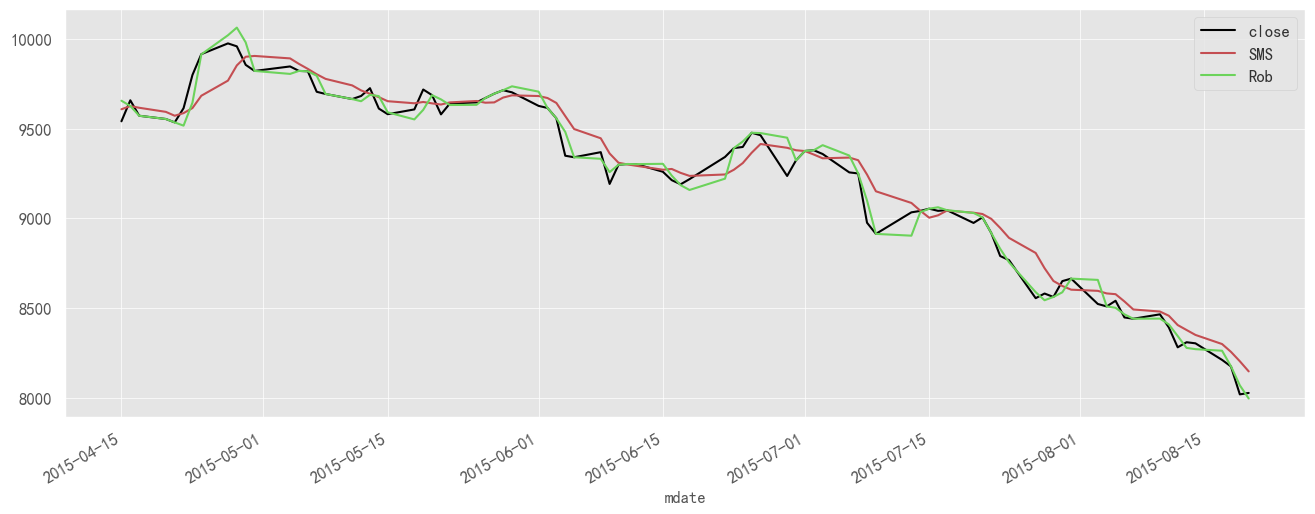

In [9]:
start_dt = pd.to_datetime("2015-04-15")
end_dt = pd.to_datetime("2015-08-20")
rob_ser:pd.Series = icu_ma.calc_icu_ma(close_ser,5)
close_ser.loc[start_dt:end_dt].plot(figsize=(16, 6), label="close", color="black")
close_ser.rolling(5).mean().loc[start_dt:end_dt].plot(color='r', label="SMS")
rob_ser.loc[start_dt:end_dt].plot(label="Rob", color="#6cd35b")
plt.legend()

In [10]:
import empyrical as ep
# 
all_df: pd.DataFrame = pd.concat(
    (
        icu_ma.calc_icu_ma(close_ser,i) for i in np.arange(5, 205, 5)
    ),
    axis=1,
)
all_df.columns = np.arange(5, 205, 5)

In [11]:
flag_frame: pd.DataFrame = (
    all_df.sub(close_ser, axis=0).mul(-1).apply(lambda x: np.where(x > 0, 1, 0))
)
cum_frame: pd.DataFrame = ep.cum_returns(flag_frame.mul(twse['roi'], axis=0))

In [12]:
cum_frame.iloc[-1].nlargest(10)

45     1.694817
50     1.340983
55     1.220325
40     1.081844
80     0.972958
105    0.954020
35     0.935709
60     0.932064
100    0.905289
110    0.844533
Name: 2025-04-21 00:00:00, dtype: float64

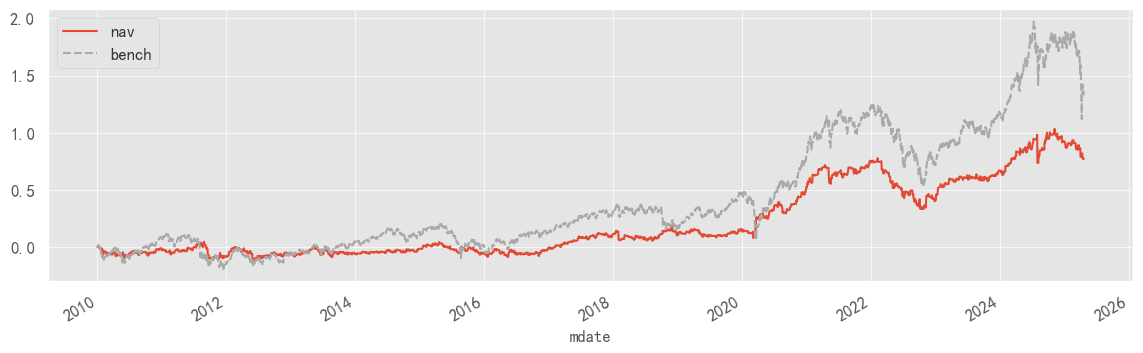

In [13]:
cum_frame[10].plot(label="nav",figsize=(14,4))
ep.cum_returns(close_ser.pct_change()).plot(label="bench", ls="--", color="darkgray")
plt.legend()

In [35]:
hs300 = twse.rename(columns={
    "open_d": "open",
    "high_d": "high",
    "low_d": "low",
    "close_d": "close",
    "vol": "volume"  # 不需改名就保留
})

In [ ]:
def multi_objective_score(x):
    ann = runstrat(x, dataset=hs300, method='ann')
    dw = runstrat(x, dataset=hs300, method='dw')
    
    if ann == -np.inf or dw == -np.inf:
        return -np.inf

    return ann - 2 * dw  # 可根據風險偏好調整權重

opt = gfo.EvolutionStrategyOptimizer(search_space)
opt.search(multi_objective_score, n_iter=iterations)

In [43]:
from typing import Dict, List, Union
import gradient_free_optimizers as gfo
search_space: Dict = {"N": np.arange(5, 205, 5)}

iterations: int = 20

def multi_objective_score(x):
    ann = runstrat(x, dataset=hs300, method='ann')
    dw = runstrat(x, dataset=hs300, method='dw')
    
    if ann == -np.inf or dw == -np.inf:
        return -np.inf

    return ann - 2 * dw  # 可根據風險偏好調整權重

opt = gfo.EvolutionStrategyOptimizer(search_space)
opt.search(multi_objective_score, n_iter=iterations)


Results: 'multi_objective_score'  
   Best score: -22.87001136540315  
   Best parameter:
      'N' : 90  
 
   Random seed: 522538412  
 
   Evaluation time   : 40.81900906562805 sec    [99.94 %]
   Optimization time : 0.0237884521484375 sec    [0.06 %]
   Iteration time    : 40.84279751777649 sec    [2.04 sec/iter]
 


{'N': 90}


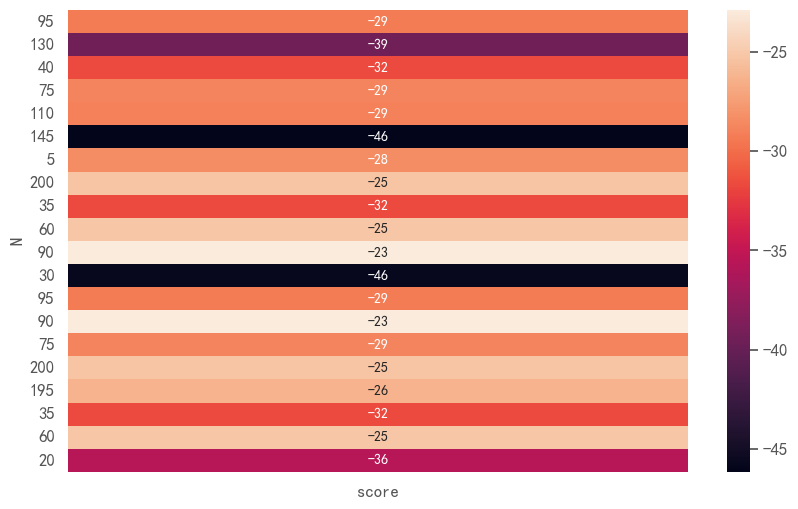

In [44]:
import seaborn as sns
sns.heatmap(opt.search_data.set_index('N'),annot=True)
print(opt.best_para)

In [45]:
result = backtest.get_backtest(hs300,**opt.best_para)

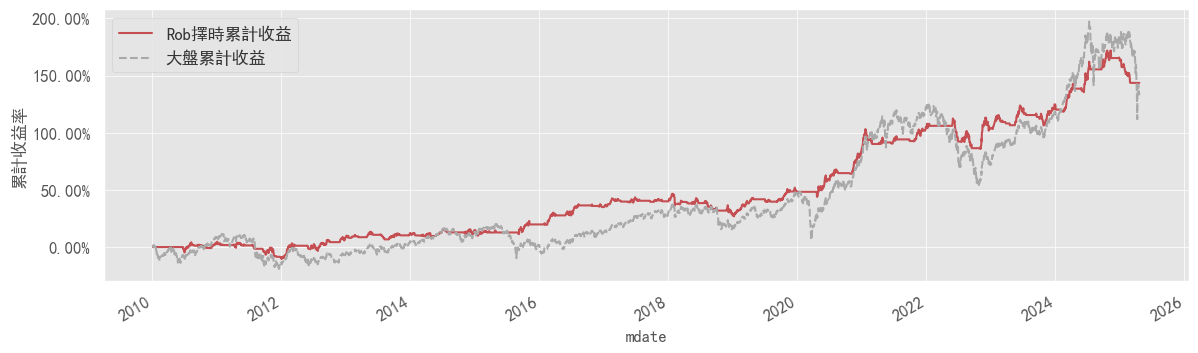

In [46]:
ret = pd.Series(result[0].analyzers._TimeReturn.get_analysis())
ax = ep.cum_returns(ret).plot(figsize=(14, 4), label="Rob擇時累計收益", color="r")
ep.cum_returns(twse["close_d"].pct_change()).plot(
    ls="--", color="darkgray", label="大盤累計收益", ax=ax
)
ax.set_ylabel('累計收益率')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.2%}".format(x)))
plt.legend()

In [47]:
import Tool

In [48]:
Tool.show_stats(ret)

,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),样本胜率(%),周胜率(%),月胜率(%),年胜率(%),盈亏比(avg_win/avg_loss),总赚赔比(profit_factor),预期报酬(bps),样本数
策略,6.32,0.77,0.28,-14.52,-14.51,25.55,30.66,45.65,75.0,1.13,1.21,2.38,3749
